# 第 10  章  数据聚合与分组运算

对数据集进行分组并对各组应用一个函数（无论是聚合还是转换），通常是数
据分析工作中的重要环节。在将数据集加载、融合、准备好之后，通常就是计
算分组统计或生成透视表。pandas 提供了一个灵活高效的 gruopby 功能，它使
你能以一种自然的方式对数据集进行切片、切块、摘要等操作。

关系型数据库和 SQL（Structured Query Language，结构化查询语言）能够如
此流行的原因之一就是其能够方便地对数据进行连接、过滤、转换和聚合。但
是，像 SQL 这样的查询语言所能执行的分组运算的种类很有限。在本章中你将
会看到，由于 Python 和 pandas 强大的表达能力，我们可以执行复杂得多的分
组运算（利用任何可以接受 pandas 对象或 NumPy 数组的函数）。在本章中，你
将会学到：
-  计算分组摘要统计，如计数、平均值、标准差，或用户自定义函数。
-  计算分组的概述统计，比如数量、平均值或标准差，或是用户定义的函数。
-  应用组内转换或其他运算，如规格化、线性回归、排名或选取子集等。
-  计算透视表或交叉表。
-  执行分位数分析以及其它统计分组分析。

笔记：对时间序列数据的聚合（groupby 的特殊用法之一）也称作重采样
（resampling），本书将在第 11 章中单独对其进行讲解。

## 10.1 GroupBy 机制
Hadley Wickham（许多热门 R 语言包的作者）创造了一个用于表示分组运算的
术语"split-apply-combine"（拆分－应用－合并）。第一个阶段，pandas 对
象（无论是 Series、DataFrame 还是其他的）中的数据会根据你所提供的一个
或多个键被拆分（split）为多组。拆分操作是在对象的特定轴上执行的。例
如，DataFrame 可以在其行（axis=0）或列（axis=1）上进行分组。然后，将
一个函数应用（apply）到各个分组并产生一个新值。最后，所有这些函数的执
行结果会被合并（combine）到最终的结果对象中。结果对象的形式一般取决于
数据上所执行的操作。图 10-1 大致说明了一个简单的分组聚合过程。

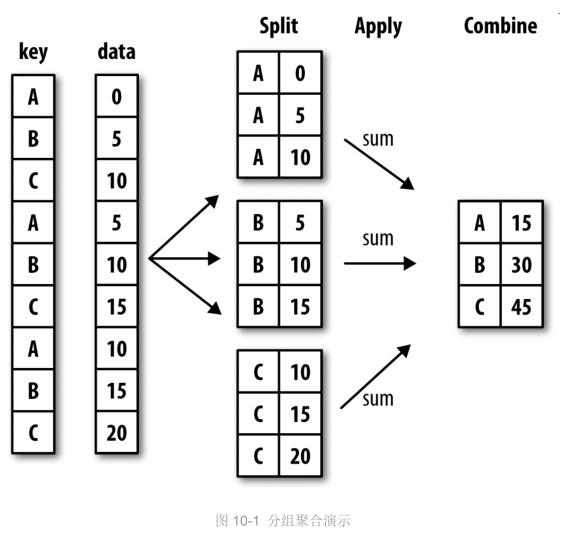

分组键可以有多种形式，且类型不必相同：
-  列表或数组，其长度与待分组的轴一样。
-  表示 DataFrame 某个列名的值。
-  字典或 Series，给出待分组轴上的值与分组名之间的对应关系。
-  函数，用于处理轴索引或索引中的各个标签。

注意，后三种都只是快捷方式而已，其最终目的仍然是产生一组用于拆分对象
的值。如果觉得这些东西看起来很抽象，不用担心，我将在本章中给出大量有
关于此的示例。首先来看看下面这个非常简单的表格型数据集（以 DataFrame
的形式）：

In [1]:
import pandas as pd
import numpy as np

In [70]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

In [71]:
df

,key1,key2,data1,data2
0,a,one,-0.717525,0.616031
1,a,two,0.032668,0.371228
2,b,one,-0.610209,-0.495648
3,b,two,-1.192963,-0.356028
4,a,one,-1.515527,-1.521119


假设你想要按 key1 进行分组，并计算 data1 列的平均值。实现该功能的方式有
很多，而我们这里要用的是：访问 data1，并根据 key1 调用 groupby：

In [72]:
grouped = df['data1'].groupby(df['key1'])

In [73]:
grouped

变量 grouped 是一个 GroupBy 对象。它实际上还没有进行任何计算，只是含有
一些有关分组键 df['key1']的中间数据而已。换句话说，该对象已经有了接下
来对各分组执行运算所需的一切信息。例如，我们可以调用 GroupBy 的 mean 方
法来计算分组平均值：

In [74]:
grouped.mean()

key1
a   -0.733462
b   -0.901586
Name: data1, dtype: float64

稍后我将详细讲解.mean()的调用过程。这里最重要的是，数据（Series）根据
分组键进行了聚合，产生了一个新的 Series，其索引为 key1 列中的唯一值。
之所以结果中索引的名称为 key1，是因为原始 DataFrame 的列 df['key1']就叫
这个名字。

如果我们一次传入多个数组的列表，就会得到不同的结果：

In [75]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [76]:
means

key1  key2
a     one    -1.116526
      two     0.032668
b     one    -0.610209
      two    -1.192963
Name: data1, dtype: float64

这里，我通过两个键对数据进行了分组，得到的 Series 具有一个层次化索引
（由唯一的键对组成）：

In [77]:
means.unstack()
# 层次化索引转换为列

key2,one,two
key1,,
a,-1.116526,0.032668
b,-0.610209,-1.192963


在这个例子中，分组键均为 Series。实际上，分组键可以是长度适当的任意数组：

In [81]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])

In [82]:
years = np.array([2005, 2005, 2006, 2005, 2006])

In [83]:
df['data1'].groupby([states, years]).mean()

California  2005    0.032668
            2006   -0.610209
Ohio        2005   -0.955244
            2006   -1.515527
Name: data1, dtype: float64

->这里没看懂，states和years是怎么和data1建立关系的？

->这里 states years data1 构成了一个临时的 DataFrame

通常，分组信息就位于相同的要处理 DataFrame 中。这里，你还可以将列名
（可以是字符串、数字或其他 Python 对象）用作分组键：

In [13]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.343005,0.774716
b,-1.283144,0.479286


In [14]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   1.021063  0.665198
     two  -1.013111  0.993753
b    one  -2.267498 -0.217249
     two  -0.298791  1.175822

你可能已经注意到了，第一个例子在执行 df.groupby('key1').mean()时，结
果中没有 key2 列。这是因为 df['key2']不是数值数据（俗称“麻烦列”），
所以被从结果中排除了。默认情况下，所有数值列都会被聚合，虽然有时可能
会被过滤为一个子集，稍后就会碰到。

无论你准备拿 groupby 做什么，都有可能会用到 GroupBy 的 size 方法，它可以
返回一个含有**分组大小**的 Series：

In [15]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

注意，任何分组关键词中的缺失值，都会被从结果中除去。
### 对分组进行迭代
GroupBy 对象支持迭代，可以产生一组二元元组（由分组名和数据块组成）。
看下面的例子：

In [16]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one  1.781230  0.658544
1    a  two -1.013111  0.993753
4    a  one  0.260897  0.671852
b
  key1 key2     data1     data2
2    b  one -2.267498 -0.217249
3    b  two -0.298791  1.175822


对于多重键的情况，元组的第一个元素将会是由键值组成的元组：

In [17]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one  1.781230  0.658544
4    a  one  0.260897  0.671852
('a', 'two')
  key1 key2     data1     data2
1    a  two -1.013111  0.993753
('b', 'one')
  key1 key2     data1     data2
2    b  one -2.267498 -0.217249
('b', 'two')
  key1 key2     data1     data2
3    b  two -0.298791  1.175822


当然，你可以对这些数据片段做任何操作。有一个你可能会觉得有用的运算：
将这些数据片段做成一个字典：

In [18]:
pieces = dict(list(df.groupby('key1')))

In [19]:
pieces

{'a':   key1 key2     data1     data2
 0    a  one  1.781230  0.658544
 1    a  two -1.013111  0.993753
 4    a  one  0.260897  0.671852, 'b':   key1 key2     data1     data2
 2    b  one -2.267498 -0.217249
 3    b  two -0.298791  1.175822}

In [20]:
pieces['b']

,key1,key2,data1,data2
2,b,one,-2.267498,-0.217249
3,b,two,-0.298791,1.175822


groupby 默认是在 axis=0 上进行分组的，通过设置也可以在其他任何轴上进行
分组。拿上面例子中的 df 来说，我们可以根据 dtype 对列进行分组：

In [21]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [22]:
grouped = df.groupby(df.dtypes, axis=1)

可以如下打印分组：

In [23]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0  1.781230  0.658544
1 -1.013111  0.993753
2 -2.267498 -0.217249
3 -0.298791  1.175822
4  0.260897  0.671852
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### 选取一列或列的子集
对于由 DataFrame 产生的 GroupBy 对象，如果用一个（单个字符串）或一组
（字符串数组）列名对其进行索引，就能实现选取部分列进行聚合的目的。也
就是说：

是以下代码的语法糖：

尤其对于大数据集，很可能只需要对部分列进行聚合。例如，在前面那个数据
集中，如果只需计算 data2 列的平均值并以 DataFrame 形式得到结果，可以这
样写：

In [24]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.665198
     two   0.993753
b    one  -0.217249
     two   1.175822

这种索引操作所返回的对象是一个已分组的 DataFrame（如果传入的是列表或
数组）或已分组的 Series（如果传入的是标量形式的单个列名）：

In [28]:
s_grouped = df.groupby(['key1', 'key2'])['data2']

In [29]:
s_grouped

In [30]:
s_grouped.mean()

key1  key2
a     one     0.665198
      two     0.993753
b     one    -0.217249
      two     1.175822
Name: data2, dtype: float64

### 通过字典或 Series 进行分组
除数组以外，分组信息还可以其他形式存在。来看另一个示例 DataFrame：

In [32]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people

,a,b,c,d,e
Joe,1.039192,-0.937287,-0.138053,-1.559359,0.279071
Steve,1.105435,-0.664403,0.515971,1.755987,-1.649533
Wes,0.576041,0.775915,-1.268393,-0.390724,0.347458
Jim,0.621419,0.549869,-0.230715,-2.067694,-0.491229
Travis,-2.135257,-0.268417,0.299582,1.931810,1.429245


In [33]:
people.iloc[2:3, [1, 2]] = np.nan 
# Add a few NA values

In [34]:
people

,a,b,c,d,e
Joe,1.039192,-0.937287,-0.138053,-1.559359,0.279071
Steve,1.105435,-0.664403,0.515971,1.755987,-1.649533
Wes,0.576041,NaN,NaN,-0.390724,0.347458
Jim,0.621419,0.549869,-0.230715,-2.067694,-0.491229
Travis,-2.135257,-0.268417,0.299582,1.931810,1.429245


现在，假设已知列的分组关系，并希望根据分组计算列的和：

In [39]:
mapping = {'a': 'red', 
           'b': 'red', 
           'c': 'blue',
           'd': 'blue', 
           'e': 'red', 
           'f' : 'orange'}

In [40]:
mapping

{'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}

现在，你可以将这个字典传给 groupby，来构造数组，但我们可以直接传递字
典（我包含了键“f”来强调，存在未使用的分组键是可以的）：

In [41]:
by_column = people.groupby(mapping, axis=1)

In [42]:
by_column.sum()

,blue,red
Joe,-1.697413,0.380975
Steve,2.271959,-1.208500
Wes,-0.390724,0.923500
Jim,-2.298408,0.680060
Travis,2.231392,-0.974428


Series 也有同样的功能，它可以被看做一个固定大小的映射：

In [43]:
map_series = pd.Series(mapping)

In [44]:
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [45]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 通过函数进行分组
比起使用字典或 Series，使用 Python 函数是一种更原生的方法定义分组映
射。任何被当做分组键的函数都会在各个索引值上被调用一次，其返回值就会
被用作分组名称。具体点说，以上一小节的示例 DataFrame 为例，其索引值为
人的名字。你可以计算一个字符串长度的数组，更简单的方法是传入 len 函
数：

-> why ?

-> people 的索引列有3种长度，分别为 3、5、6

In [46]:
people.groupby(len).sum()

,a,b,c,d,e
3,2.236652,-0.387418,-0.368768,-4.017777,0.135300
5,1.105435,-0.664403,0.515971,1.755987,-1.649533
6,-2.135257,-0.268417,0.299582,1.931810,1.429245


将函数跟数组、列表、字典、Series 混合使用也不是问题，因为任何东西在内
部都会被转换为数组：

In [47]:
key_list = ['one', 'one', 'one', 'two', 'two']

In [48]:
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one  0.576041 -0.937287 -0.138053 -1.559359  0.279071
  two  0.621419  0.549869 -0.230715 -2.067694 -0.491229
5 one  1.105435 -0.664403  0.515971  1.755987 -1.649533
6 two -2.135257 -0.268417  0.299582  1.931810  1.429245

### 根据索引级别分组
层次化索引数据集最方便的地方就在于它能够根据轴索引的一个级别进行聚
合：

In [49]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                     [1, 3, 5, 1, 3]],
                                    names=['cty', 'tenor'])
columns

MultiIndex(levels=[['JP', 'US'], [1, 3, 5]],
           labels=[[1, 1, 1, 0, 0], [0, 1, 2, 0, 1]],
           names=['cty', 'tenor'])

In [50]:
hier_df = pd.DataFrame(np.random.randn(4, 5),
                       columns=columns)

In [51]:
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.624939  0.219732  2.003415  0.510423 -0.645125
1     -0.604322 -1.089089  0.100563 -3.081578 -0.909639
2      0.713453 -0.708231 -1.365306  0.254277  0.213159
3     -1.595609 -1.125097 -0.000468  0.953230 -0.615268

要根据级别分组，使用 level 关键字传递级别序号或名字：

In [52]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 10.2 数据聚合
聚合指的是任何能够从数组产生标量值的数据转换过程。之前的例子已经用过
一些，比如 mean、count、min 以及 sum 等。你可能想知道在 GroupBy 对象上调
用 mean()时究竟发生了什么。许多常见的聚合运算（如表 10-1 所示）都有进
行优化。然而，除了这些方法，你还可以使用其它的。

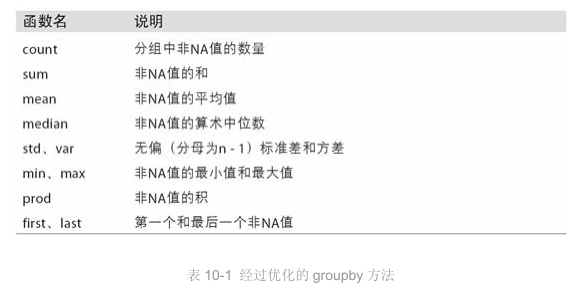

你可以使用自己发明的聚合运算，还可以调用分组对象上已经定义好的任何方
法。例如，quantile 可以计算 Series 或 DataFrame 列的样本分位数。
虽然 quantile 并没有明确地实现于 GroupBy，但它是一个 Series 方法，所以
这里是能用的。实际上，GroupBy 会高效地对 Series 进行切片，然后对各片调
用 piece.quantile(0.9)，最后将这些结果组装成最终结果：

In [53]:
df

,key1,key2,data1,data2
0,a,one,1.781230,0.658544
1,a,two,-1.013111,0.993753
2,b,one,-2.267498,-0.217249
3,b,two,-0.298791,1.175822
4,a,one,0.260897,0.671852


In [54]:
grouped = df.groupby('key1')

In [55]:
grouped['data1']

In [56]:
grouped['data1'].quantile(0.9)

key1
a    1.477163
b   -0.495661
Name: data1, dtype: float64

如果要使用你自己的聚合函数，只需将其传入 aggregate 或 agg 方法即可：

In [57]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

In [58]:
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.794340,0.335209
b,1.968707,1.393071


你可能注意到注意，有些方法（如 describe）也是可以用在这里的，即使严格
来讲，它们并非聚合运算：

In [59]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.343005  1.398979 -1.013111 -0.376107  0.260897  1.021063   
b      2.0 -1.283144  1.392086 -2.267498 -1.775321 -1.283144 -0.790968   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     1.781230   3.0  0.774716  0.189808  0.658544  0.665198  0.671852   
b    -0.298791   2.0  0.479286  0.985050 -0.217249  0.131019  0.479286   

                          
           75%       max  
key1                      
a     0.832802  0.993753  
b     0.827554  1.175822

在后面的 10.3 节，我将详细说明这到底是怎么回事。

笔记：自定义聚合函数要比表 10-1 中那些经过优化的函数慢得多。这是因为在
构造中间分组数据块时存在非常大的开销（函数调用、数据重排等）。
### 面向列的多函数应用
回到前面小费的例子。使用 read_csv 导入数据之后，我们添加了一个小费百分
比的列 tip_pct：

In [2]:
tips = pd.read_csv('examples/tips.csv')

In [3]:
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [4]:
tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


你已经看到，对 Series 或 DataFrame 列的聚合运算其实就是使用 aggregate
（使用自定义函数）或调用诸如 mean、std 之类的方法。然而，你可能希望对
不同的列使用不同的聚合函数，或一次应用多个函数。其实这也好办，我将通
过一些示例来进行讲解。首先，我根据天和 smoker 对 tips 进行分组：

In [63]:
grouped = tips.groupby(['day', 'smoker'])

注意，对于表 10-1 中的那些描述统计，可以将函数名以字符串的形式传入：

In [64]:
grouped_pct = grouped['tip_pct']

In [65]:
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

如果传入一组函数或函数名，得到的 DataFrame 的列就会以相应的函数命名：

In [66]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

这里，我们传递了一组聚合函数进行聚合，独立对数据分组进行评估。

你并非一定要接受 GroupBy 自动给出的那些列名，特别是 lambda 函数，它们的
名称是'<lambda>'，这样的辨识度就很低了（通过函数的 e name 属性看看就知道
了）。因此，如果传入的是一个由(name,function)元组组成的列表，则各元组
的第一个元素就会被用作 DataFrame 的列名（可以将这种二元元组列表看做一
个有序映射）：

In [68]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

对于 DataFrame，你还有更多选择，你可以定义一组应用于全部列的一组函
数，或不同的列应用不同的函数。假设我们想要对 tip_pct 和 total_bill 列计
算三个统计信息：

In [69]:
functions = ['count', 'mean', 'max']

In [70]:
result = grouped['tip_pct', 'total_bill'].agg(functions)

In [71]:
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

如你所见，结果 DataFrame 拥有层次化的列，这相当于分别对各列进行聚合，
然后用 concat 将结果组装到一起，使用列名用作 keys 参数：

In [72]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

跟前面一样，这里也可以传入带有自定义名称的一组元组：

In [73]:
ftuples = [('Durchschnitt', 'mean'),('Abweichung', np.var)]

In [74]:
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

现在，假设你想要对一个列或不同的列应用不同的函数。具体的办法是向 agg
传入一个从列名映射到函数的字典：

In [75]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [76]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

只有将多个函数应用到至少一列时，DataFrame 才会拥有层次化的列。

### 以“没有行索引”的形式返回聚合数据
到目前为止，所有示例中的聚合数据都有由唯一的分组键组成的索引（可能还
是层次化的）。由于并不总是需要如此，所以你可以向 groupby 传入
`as_index=False` 以禁用该功能：

In [11]:
tips.head(6)

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


In [6]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


当然，对结果调用 reset_index 也能得到这种形式的结果。使用
as_index=False 方法可以避免一些不必要的计算。----**提高效率**-----
## 10.3 apply：一般性的“拆分－应用－合并”

最通用的 GroupBy 方法是 apply，本节剩余部分将重点讲解它。如图 10-2 所
示，apply 会将待处理的对象拆分成多个片段，然后对各片段调用传入的函
数，最后尝试将各片段组合到一起。

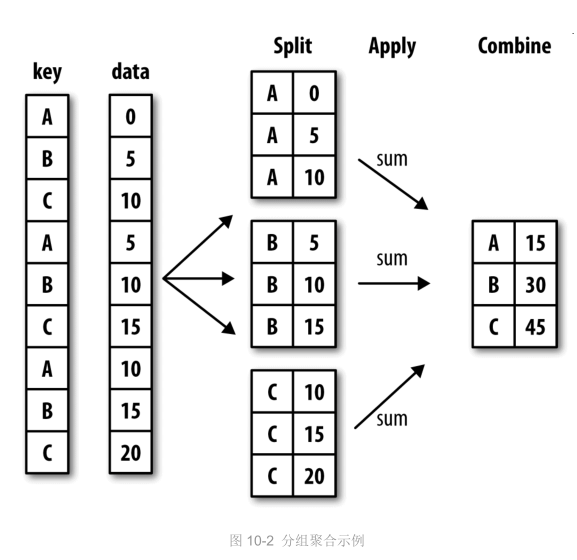

回到之前那个小费数据集，假设你想要根据分组选出最高的 5 个 tip_pct 值。
首先，编写一个选取指定列具有最大值的行的函数：

In [12]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

In [17]:
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


现在，如果对 smoker 分组并用该函数调用 apply，就会得到：

In [18]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

这里发生了什么？top 函数在 DataFrame 的各个片段上调用，然后结果由
pandas.concat 组装到一起，并以分组名称进行了标记。于是，最终结果就有
了一个层次化索引，其内层索引值来自原 DataFrame。

如果传给 apply 的函数能够接受其他参数或关键字，则可以将这些内容放在函
数名后面一并传入：

In [20]:
tips.groupby(['smoker', 'day']).apply(top, n=2, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  91        22.49   3.50     No   Fri  Dinner     2  0.155625
            94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  59        48.27   6.73     No   Sat  Dinner     4  0.139424
            212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  112       38.07   4.00     No   Sun  Dinner     3  0.105070
            156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 85        34.83   5.17     No  Thur   Lunch     4  0.148435
            142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  90        28.97   3.00    Yes   Fri  Dinner     2  0.103555
            95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  102       44.30   2.50    Yes   Sat  Dinner     3  0.056433
            170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  184       40.55   3.00    Yes   Sun  Dinner     2  0.073983
            182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 83        32.68   5.00    Yes  Thur   Lunch     2  0.152999
            197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

笔记：除这些基本用法之外，能否充分发挥 apply 的威力很大程度上取决于你
的创造力。传入的那个函数能做什么全由你说了算，它只需返回一个 pandas 对
象或标量值即可。本章后续部分的示例主要用于讲解如何利用 groupby 解决各
种各样的问题。

可能你已经想起来了，之前我在 GroupBy 对象上调用过 describe：

In [21]:
result = tips.groupby('smoker')['tip_pct'].describe()

In [22]:
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [23]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

在 GroupBy 中，当你调用诸如 describe 之类的方法时，实际上只是应用了下面
两条代码的快捷方式而已：

`f = lambda x: x.describe()
grouped.apply(f)`
### 禁止分组键
从上面的例子中可以看出，分组键会跟原始对象的索引共同构成结果对象中的
层次化索引。将 group_keys=False 传入 groupby 即可禁止该效果：

In [24]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


### 分位数和桶分析
我曾在第 8 章中讲过，pandas 有一些能根据指定面元或样本分位数将数据拆分
成多块的工具（比如 cut 和 qcut）。将这些函数跟 groupby 结合起来，就能非
常轻松地实现对数据集的桶（bucket）或分位数（quantile）分析了。以下面
这个简单的随机数据集为例，我们利用 cut 将其装入长度相等的桶中：

In [25]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})

In [26]:
frame

,data1,data2
0,-0.887528,-0.249180
1,1.581862,-0.509167
2,-0.337128,-0.393361
3,-0.307723,-0.287082
4,-0.150942,0.574839
5,1.270260,0.257274
6,0.023975,-0.107423
7,-0.678328,0.802550
8,0.846456,0.333747
9,1.316729,0.784854


In [27]:
quartiles = pd.cut(frame.data1, 4)

In [28]:
quartiles[:10]

0    (-1.579, 0.104]
1     (0.104, 1.787]
2    (-1.579, 0.104]
3    (-1.579, 0.104]
4    (-1.579, 0.104]
5     (0.104, 1.787]
6    (-1.579, 0.104]
7    (-1.579, 0.104]
8     (0.104, 1.787]
9     (0.104, 1.787]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.269, -1.579] < (-1.579, 0.104] < (0.104, 1.787] < (1.787, 3.471]]

由 cut 返回的 Categorical 对象可直接传递到 groupby。因此，我们可以像下
面这样对 data2 列做一些统计计算：

In [29]:
def get_stats(group):
    return {'min': group.min(), 
            'max': group.max(),
            'count': group.count(), 
            'mean': group.mean()}

In [33]:
grouped = frame.data2.groupby(quartiles)
# 按照 data1 分组 data2

In [31]:
grouped

In [32]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.269, -1.579]",57.0,1.880090,0.004524,-2.164678
"(-1.579, 0.104]",496.0,2.398100,-0.050826,-3.667121
"(0.104, 1.787]",410.0,2.823021,0.058028,-2.453898
"(1.787, 3.471]",37.0,2.215776,0.087682,-2.201390


这些都是长度相等的桶。要根据样本分位数得到大小相等的桶，使用 qcut 即
可。传入 labels=False 即可只获取分位数的编号：

In [34]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=False)

In [35]:
grouping
# 第二列即为按照data1 得到的分位数编号，桶编号，分段编号

0      1
1      9
2      3
3      3
4      4
5      9
6      5
7      2
8      8
9      9
10     3
11     5
12     5
13     3
14     6
15     9
16     4
17     2
18     8
19     5
20     8
21     3
22     9
23     5
24     5
25     4
26     4
27     9
28     4
29     7
      ..
970    8
971    4
972    8
973    2
974    1
975    7
976    8
977    0
978    2
979    8
980    1
981    0
982    2
983    9
984    5
985    6
986    7
987    9
988    7
989    9
990    6
991    2
992    4
993    4
994    7
995    2
996    1
997    8
998    9
999    2
Name: data1, Length: 1000, dtype: int64

In [36]:
grouped = frame.data2.groupby(grouping)

In [37]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.209291,-0.025166,-3.667121
1,100.0,1.963296,-0.143584,-2.161592
2,100.0,2.050667,-0.064009,-2.258200
3,100.0,2.040346,-0.153259,-2.845949
4,100.0,2.398100,0.172093,-2.469051
5,100.0,2.199037,-0.048108,-2.876976
6,100.0,2.771374,0.179166,-1.950246
7,100.0,2.587342,-0.062540,-2.297760
8,100.0,2.823021,0.061252,-2.406246


我们会在第 12 章详细讲解 pandas 的 Categorical 类型。
### 示例：用特定于分组的值填充缺失值
对于缺失数据的清理工作，有时你会用 dropna 将其替换掉，而有时则可能会希
望用一个固定值或由数据集本身所衍生出来的值去填充 NA 值。这时就得使用
fillna 这个工具了。在下面这个例子中，我用平均值去填充 NA 值：

In [39]:
s = pd.Series(np.random.randn(6))
s

0   -0.917010
1   -0.748403
2   -1.211038
3   -1.399132
4    1.459988
5    0.753534
dtype: float64

In [40]:
s[::2] = np.nan
s

0         NaN
1   -0.748403
2         NaN
3   -1.399132
4         NaN
5    0.753534
dtype: float64

In [41]:
s.fillna(s.mean())

0   -0.464667
1   -0.748403
2   -0.464667
3   -1.399132
4   -0.464667
5    0.753534
dtype: float64

假设你需要对不同的分组填充不同的值。一种方法是将数据分组，并使用
apply 和一个能够对各数据块调用 fillna 的函数即可。下面是一些有关美国几
个州的示例数据，这些州又被分为东部和西部：

In [8]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'California', 'Idaho']

In [9]:
group_key = ['East'] * 4 + ['West'] * 4

In [10]:
data = pd.Series(np.random.randn(8), index=states)

In [11]:
data

Ohio         -3.545590
New York      0.374483
Vermont      -0.513282
Florida       0.188293
Oregon       -0.274860
Nevada        0.117104
California   -0.048348
Idaho         1.813151
dtype: float64

`['East'] * 4 `产生了一个列表，包括了 `['East']` 中元素的四个拷贝。将这些列
表串联起来。

将一些值设为缺失：

In [13]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan

In [14]:
data

Ohio         -3.545590
New York      0.374483
Vermont            NaN
Florida       0.188293
Oregon       -0.274860
Nevada             NaN
California   -0.048348
Idaho              NaN
dtype: float64

In [15]:
data.groupby(group_key).mean()

East   -0.994271
West   -0.161604
dtype: float64

我们可以用分组平均值去填充 NA 值:

In [16]:
fill_mean = lambda g: g.fillna(g.mean())

In [17]:
data.groupby(group_key)

In [18]:
data.groupby(group_key).apply(fill_mean)

Ohio         -3.545590
New York      0.374483
Vermont      -0.994271
Florida       0.188293
Oregon       -0.274860
Nevada       -0.161604
California   -0.048348
Idaho        -0.161604
dtype: float64

此外，也可以在代码中预定义各组的填充值。由于分组具有一个 name 属性，所以
我们可以拿来用一下：

In [19]:
fill_values = {'East': 0.5, 'West': -1}

In [20]:
fill_func = lambda g: g.fillna(fill_values[g.name])

In [21]:
data.groupby(group_key).apply(fill_func)

Ohio         -3.545590
New York      0.374483
Vermont       0.500000
Florida       0.188293
Oregon       -0.274860
Nevada       -1.000000
California   -0.048348
Idaho        -1.000000
dtype: float64

### 示例：随机采样和排列
假设你想要从一个大数据集中随机抽取（进行替换或不替换）样本以进行蒙特
卡罗模拟（Monte Carlo simulation）或其他分析工作。“抽取”的方式有很
多，这里使用的方法是对 Series 使用 sample 方法：

In [22]:
# Hearts, Spades, Clubs, Diamonds
# 棋牌：红桃 黑桃 梅花 方片，主牌52张，副牌2张
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)
deck = pd.Series(card_val, index=cards)

现在我有了一个长度为 52 的 Series，其索引包括牌名，值则是 21 点或其他游
戏中用于计分的点数（为了简单起见，我当 A 的点数为 1）：

In [23]:
deck

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
AS      1
2S      2
3S      3
4S      4
5S      5
6S      6
7S      7
8S      8
9S      9
10S    10
JS     10
KS     10
QS     10
AC      1
2C      2
3C      3
4C      4
5C      5
6C      6
7C      7
8C      8
9C      9
10C    10
JC     10
KC     10
QC     10
AD      1
2D      2
3D      3
4D      4
5D      5
6D      6
7D      7
8D      8
9D      9
10D    10
JD     10
KD     10
QD     10
dtype: int64

In [24]:
def draw(deck, n=5):
    return deck.sample(n)

In [25]:
draw(deck)

7C      7
QD     10
5H      5
8D      8
10C    10
dtype: int64

In [26]:
draw(deck)

KD    10
AH     1
8H     8
QC    10
4C     4
dtype: int64

假设你想要从每种花色中随机抽取两张牌。由于花色是牌名的最后一个字符，
所以我们可以据此进行分组，并使用 apply：

In [27]:
get_suit = lambda card: card[-1] # last letter is suit

In [28]:
deck.groupby(get_suit).apply(draw, n=2)

C  8C      8
   KC     10
D  2D      2
   10D    10
H  7H      7
   10H    10
S  3S      3
   2S      2
dtype: int64

或者，也可以这样写：

In [29]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

3C     3
KC    10
JD    10
QD    10
7H     7
5H     5
AS     1
6S     6
dtype: int64

In [30]:
deck.groupby(get_suit).apply(draw, n=2)

C  2C      2
   JC     10
D  QD     10
   5D      5
H  10H    10
   4H      4
S  JS     10
   3S      3
dtype: int64

### 示例：分组加权平均数和相关系数
根据 groupby 的“拆分－应用－合并”范式，可以进行 DataFrame 的列与列之
间或两个 Series 之间的运算（比如分组加权平均）。以下面这个数据集为例，
它含有分组键、值以及一些权重值：

In [31]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.rand(8)})

In [32]:
df

,category,data,weights
0,a,0.120146,0.818657
1,a,0.088450,0.739227
2,a,0.420786,0.626139
3,a,-0.115679,0.086471
4,b,0.521493,0.291359
5,b,-3.273412,0.103471
6,b,-0.211842,0.990547
7,b,-0.557743,0.128925


然后可以利用 category 计算分组加权平均数：

In [33]:
grouped = df.groupby('category')

# why ?

In [34]:
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
# weights 是用于加权的权重，先加权再平均

In [35]:
grouped.apply(get_wavg)

category
a    0.183753
b   -0.309389
dtype: float64

另一个例子，考虑一个来自 Yahoo!Finance 的数据集，其中含有几只股票和标
准普尔 500 指数（符号 SPX）的收盘价：

In [36]:
close_px = pd.read_csv('examples/stock_px_2.csv',
                       parse_dates=True,
                       index_col=0)

In [37]:
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [38]:
close_px.head(4)

,AAPL,MSFT,XOM,SPX
2003-01-02,7.40,21.11,29.22,909.03
2003-01-03,7.45,21.14,29.24,908.59
2003-01-06,7.45,21.52,29.96,929.01
2003-01-07,7.43,21.93,28.95,922.93


In [39]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


来做一个比较有趣的任务：计算一个由日收益率（通过百分数变化计算）与
SPX 之间的年度相关系数组成的 DataFrame。下面是一个实现办法，我们先创建
一个函数，用它计算每列和 SPX 列的成对相关系数：

In [40]:
spx_corr = lambda x: x.corrwith(x['SPX'])

接下来，我们使用 pct_change 计算 close_px 的百分比变化：

In [41]:
rets = close_px.pct_change().dropna()
rets[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,0.029526,0.002227,-0.000131,0.000544
2011-10-12,0.004747,-0.001481,0.011669,0.009795
2011-10-13,0.015515,0.008160,-0.010238,-0.002974
2011-10-14,0.033225,0.003311,0.022784,0.017380


最后，我们用年对百分比变化进行分组，可以用一个一行的函数，从每行的标
签返回每个 datetime 标签的 year 属性：

In [42]:
get_year = lambda x: x.year

In [43]:
by_year = rets.groupby(get_year)

In [44]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


当然，你还可以计算列与列之间的相关系数。这里，我们计算 Apple 和
Microsoft 的年相关系数：

In [45]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 示例：组级别的线性回归
顺着上一个例子继续，你可以用 groupby 执行更为复杂的分组统计分析，只要
函数返回的是 pandas 对象或标量值即可。例如，我可以定义下面这个 regress
函数（利用 statsmodels 计量经济学库）对各数据块执行普通最小二乘法
（Ordinary Least Squares，OLS）回归：

In [46]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.0
    result = sm.OLS(Y, X).fit()
    return result.params

现在，为了按年计算 AAPL 对 SPX 收益率的线性回归，执行：

In [47]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


## 10.4 透视表和交叉表
透视表（pivot table）是各种电子表格程序和其他数据分析软件中一种常见的
数据汇总工具。它根据一个或多个键对数据进行聚合，并根据行和列上的分组
键将数据分配到各个矩形区域中。在 Python 和 pandas 中，可以通过本章所介
绍的 groupby 功能以及（能够利用层次化索引的）重塑运算制作透视表。
DataFrame 有一个 pivot_table 方法，此外还有一个顶级的
pandas.pivot_table 函数。除能为 groupby 提供便利之外，pivot_table 还可
以添加分项小计，也叫做 margins。

回到小费数据集，假设我想要根据 day 和 smoker 计算分组平均数
（pivot_table 的默认聚合类型），并将 day 和 smoker 放到行上：

In [48]:
tips.pivot_table(index=['day', 'smoker'])
# pivot_table 默认聚合均值 mean()

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

本来也可以用 groupby 直接来做。现在，假设我们只想聚合 tip_pct 和 size，而且想
根据 time 进行分组。我将 smoker 放到列上，把 day 放到行上：

In [49]:
tips.head()

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808


In [50]:
tips.pivot_table(['tip_pct', 'size'], 
                 index=['time', 'day'],
                 columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

还可以对这个表作进一步的处理，传入 margins=True 添加分项小计。这将会添
加标签为 All 的行和列，其值对应于单个等级中所有数据的分组统计：

In [51]:
tips.pivot_table(['tip_pct', 'size'], 
                 index=['time', 'day'],
                 columns='smoker', 
                 margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [52]:
tips.pivot_table(['tip_pct', 'size'], 
                 index=['time', 'day'],
                 columns='smoker', 
                 aggfunc='mean', 
                 margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

这里，All 值为平均数：不单独考虑烟民与非烟民（All 列），不单独考虑行分
组两个级别中的任何单项（All 行）。
要使用其他的聚合函数，将其传给 aggfunc 即可。例如，使用 count 或 len 可
以得到有关分组大小的交叉表（计数或频率）：

In [53]:
tips.pivot_table('tip_pct', 
                 index=['time', 'smoker'],
                 columns='day',
                 aggfunc=len, 
                 margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

In [54]:
tips.pivot_table('tip_pct', 
                 index=['time', 'smoker'],
                 columns='day',
                 aggfunc='count', 
                 margins=True)

day             Fri   Sat   Sun  Thur  All
time   smoker                             
Dinner No       3.0  45.0  57.0   1.0  106
       Yes      9.0  42.0  19.0   NaN   70
Lunch  No       1.0   NaN   NaN  44.0   45
       Yes      6.0   NaN   NaN  17.0   23
All            19.0  87.0  76.0  62.0  244

如果存在空的组合（也就是 NA），你可能会希望设置一个 fill_value

In [55]:
tips.pivot_table('tip_pct', 
                 index=['time', 'size', 'smoker'],
                 columns='day', 
                 aggfunc='mean',
                 fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

pivot_table 的参数说明请参见表 10-2。

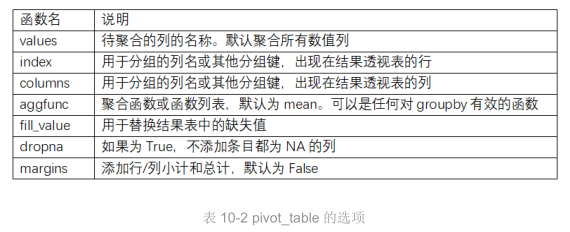

### 交叉表：crosstab
交叉表（cross-tabulation，简称 crosstab）是一种用于计算分组频率的特殊
透视表。看下面的例子：

In [63]:
datas = pd.read_csv('examples/data_sample.csv')

In [64]:
datas

,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


作为调查分析的一部分，我们可能想要根据国籍和用手习惯对这段数据进行统
计汇总。虽然可以用 pivot_table 实现该功能，但是 pandas.crosstab 函数会
更方便：

In [65]:
pd.crosstab(datas.Nationality, datas.Handedness, margins=True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


ab 的前两个参数可以是数组或 Series，或是数组列表。就像小费数据：

In [66]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## 10.5 总结
掌握 pandas 数据分组工具既有助于数据清理，也有助于建模或统计分析工作。
在第 14 章，我们会看几个例子，对真实数据使用 groupby。
在下一章，我们将关注时间序列数据。